In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd  '/content/drive/My Drive/input_data'

/content/drive/My Drive/input_data


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [ ]:
# Functoin to find contours in the license plate
def find_contours(dimensions, img):

    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Estimation of the potential dimensions
    lower_width = dimensions[0]+12.5
    upper_width = dimensions[1]+7.5
    lower_height = dimensions[2]-15
    upper_height = dimensions[3]

    # Check the largest N contours in license plate
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:8]
    ii = cv2.imread('contour.jpg')

    x_cntr_list = []
    img_res = []

    for cntr in cntrs :
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        #compare dimensions
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :

            # stores the x coordinate of the character's contour, to used later for indexing the contours
            x_cntr_list.append(intX)
            char_copy = np.zeros((44,24))

            #extracting characters
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))

            # Draw rectangle around contour
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            char = cv2.subtract(255, char)

            char_copy[2:42, 2:22] = char
            '''
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0
            '''
            # unsorted
            img_res.append(char_copy)

    # stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []

    for idx in indices:
        img_res_copy.append(img_res[idx])

    img_res = np.array(img_res_copy)

    return img_res

In [ ]:
# Preprocess license plate image
def process_image(image):

    res_img = cv2.resize(image, (333, 75))
    gray_img = cv2.cvtColor(res_img, cv2.COLOR_BGR2GRAY)
    _, binary_img = cv2.threshold(gray_img, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)


    # Erosion
    binary_img = cv2.erode(binary_img, (3,3))

    # Dilation
    binary_img = cv2.dilate(binary_img, (3,3))

    LP_WIDTH = binary_img.shape[0]
    LP_HEIGHT = binary_img.shape[1]

    # Sizes Estimations of countours in license plates
    dimensions = [0, LP_WIDTH, 0, LP_HEIGHT]

    plt.imshow(binary_img, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',binary_img)
    char_list = find_contours(dimensions, binary_img)

    return char_list

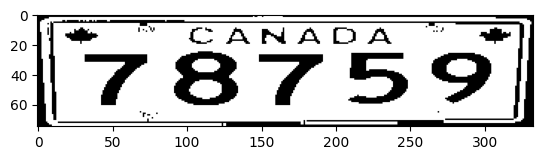

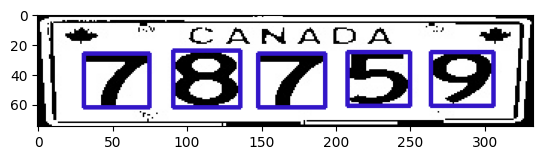

In [ ]:
img = cv2.imread('net3.jpg')
char = process_image(img)

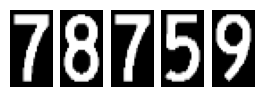

In [ ]:
for i in range(len(char)):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

In [ ]:
import tensorflow as tf


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
train_generator = train_datagen.flow_from_directory(
        '/content/drive/My Drive/input_data/train',
        target_size=(28,28), # all images will be resized to 28x28
        batch_size=1,
        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
        '/content/drive/My Drive/input_data/validation',
        target_size=(28,28),  # all images will be resized to 28x28
        class_mode='categorical')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from tensorflow.keras import optimizers

In [ ]:
model = Sequential()
model.add(Conv2D(32, (5,5), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.00001), metrics=['accuracy'])

In [ ]:
batch_size = 1
model.fit_generator(
      train_generator,
      validation_data = validation_generator,
      epochs = 30)


<ipython-input-12-405eb20dece6>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/30
864/864 [==============================] - 316s 354ms/step - loss: 1.9814 - accuracy: 0.4722 - val_loss: 0.6534 - val_accuracy: 0.7870
Epoch 2/30
864/864 [==============================] - 5s 6ms/step - loss: 0.4267 - accuracy: 0.8704 - val_loss: 0.3606 - val_accuracy: 0.8981
Epoch 3/30
864/864 [==============================] - 5s 6ms/step - loss: 0.2326 - accuracy: 0.9155 - val_loss: 0.1493 - val_accuracy: 0.9444
Epoch 4/30
864/864 [==============================] - 6s 7ms/step - loss: 0.2005 - accuracy: 0.9294 - val_loss: 0.0888 - val_accuracy: 0.9722
Epoch 5/30
864/864 [==============================] - 5s 6ms/step - loss: 0.1742 - accuracy: 0.9444 - val_loss: 0.1498 - val_accuracy: 0.9491
Epoch 6/30
864/864 [==============================] - 5s 5ms/step - loss: 0.1645 - accuracy: 0.9398 - val_loss: 0.0844 - val_accuracy: 0.9769
Epoch 7/30
864/864 [==============================] - 6s 7ms/step - loss: 0.1195 - accuracy: 0.9572 - val_loss: 0.1392 - val_accuracy: 0.9583
Ep

In [ ]:
def fix_dimension(img):
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img

def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28))
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        #predicting the class
        y_predict=model.predict(img)[0]
        y_class=np.argmax(y_predict)
        character = dic[y_class] #
        output.append(character) #storing the result in a list

    plate_number = ''.join(output)

    return plate_number


In [ ]:
print(show_results())


1/1 [==============================] - 0s 29ms/step
78759


1/1 [==============================] - 0s 17ms/step


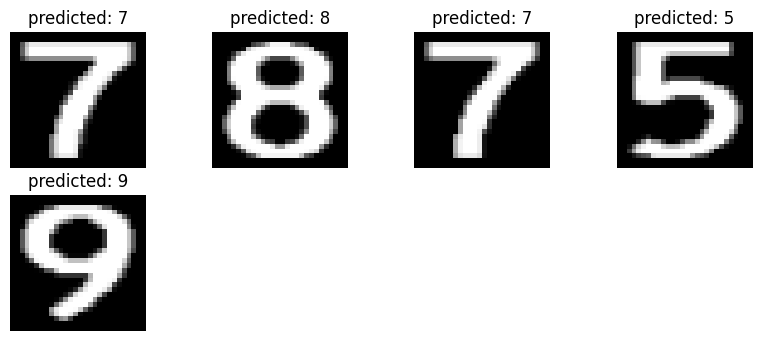

In [ ]:


plt.figure(figsize=(10,6))

for i,ch in enumerate(char):
        img = cv2.resize(ch, (28,28))
        plt.subplot(3,4,i+1)
        plt.imshow(img,cmap='gray')
        plt.title(f'predicted: {show_results()[i]}')
        plt.axis('off')
plt.show()



